In [ ]:
#| hide
import logging

# Turn off logging for datasets
logging.getLogger("datasets").setLevel(logging.ERROR)

# Tutorial - Code Analysis

> Explore the performance of code models on different code constructs!

In [ ]:
# from datasets import load_dataset

# dataset = load_dataset(
#   "codeparrot/github-code",
#   split="train",
#   streaming=True,
#   languages=["Python"],
#   licenses=["gpl-3.0"],
# )
# dataset = load_dataset("bigcode/the-stack-smol", data_dir="data/python", split="train").select(range(5_000))

In [ ]:
# !pip install -U git+https://github.com/ncoop57/code_tokenizers.git
!download_grammars

In [ ]:
1+1

In [1]:
#|eval: false
from datasets import load_dataset
from tqdm.auto import tqdm

ds = load_dataset("bigcode/the-stack-smol", data_dir="data/python", split="train").select(range(5_000))
filtered_ds = ds.filter(lambda example: len(example["content"]) < 4096)

Using custom data configuration bigcode--the-stack-smol-7b51f8bde3058781
Found cached dataset json (/transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-b38dcc32a872398b.arrow


In [2]:
len(filtered_ds)

3072

In [3]:
def find_duplicates(items):
  # Create an empty set to store the items that we have already seen
  seen = set()

  # Create an empty list to store the duplicates that we find
  duplicates = []

  # Loop through each item in the list
  for item in items:
    # If the item is already in the "seen" set, then it must be a duplicate
    if item in seen:
      # Add the duplicate to the list
      duplicates.append(item)
    # If the item is not in the "seen" set, then add it to the set
    else:
      seen.add(item)

  # Return the list of duplicates
  return duplicates

In [4]:
repo_names = find_duplicates(filtered_ds["repository_name"])

In [5]:
len(repo_names)

73

In [6]:
repo_files = {}
for repo_name in repo_names:
    rows_w_repo = filtered_ds.filter(lambda example: example["repository_name"] == repo_name)

    if len(rows_w_repo) > 1:
        repo_files[repo_name] = [row["content"] for row in rows_w_repo]
        if len(repo_files) > 100:
            break

Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-0dd594043cdb7dfb.arrow
Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-9e8d9f11675f0fd5.arrow
Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-617ac77a84286d46.arrow
Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-fa7394602e11c848.arrow
Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b

In [7]:
len(filtered_ds)

3072

In [8]:
# filter out repos with only one file
filtered_ds = filtered_ds.filter(lambda example: example["repository_name"] in repo_files)

Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-372efa95fb14c1f5.arrow


In [9]:
len(filtered_ds)

125

In [10]:
#|eval: false
from code_tokenizers.core import CodeTokenizer
from transformers import AutoModelForCausalLM

model_name = "codeparrot/codeparrot-small"
py_tokenizer = CodeTokenizer.from_pretrained(model_name, "python", padding_token="<|endoftext|>")
model = AutoModelForCausalLM.from_pretrained(model_name)
py_tokenizer.tokenizer

PreTrainedTokenizerFast(name_or_path='codeparrot/codeparrot-small', vocab_size=32768, model_max_len=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'})

In [11]:
#|eval: false
from code_tokenizers.helpers import get_internal_methods

# internal_methods = get_internal_methods(repo_files["reduceus/connect-python-sdk"], py_tokenizer)
# internal_methods

In [12]:
#|eval: false
# add the internal methods to the dataset
filtered_ds = filtered_ds.map(lambda example: {"internal_methods": get_internal_methods(repo_files[example["repository_name"]], py_tokenizer)})

Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-f1a136b0723ba303.arrow


In [ ]:
filtered_ds[1]

In [13]:
#|eval: false
from transformers import default_data_collator

def code_collator(batch):
    merged_ast = []
    for b in batch:
        merged_ast.append(b.pop("merged_ast"))

    batch = default_data_collator(batch)
    batch["merged_ast"] = merged_ast
    return batch

In [28]:
#|eval: false
from functools import partial
def tokenizer_wrapper(tokenizer, example, column, *args, **kwargs):
    # print(example["internal_methods"])
    return tokenizer(example[column], internal_methods=example["internal_methods"], *args, **kwargs)
    # return tokenizer(example["content"])

tokenizer = partial(tokenizer_wrapper, py_tokenizer, column="content")

In [29]:
tokenizer.decode = py_tokenizer.decode

In [30]:
#|eval: false
from perplexed.core import perplexed

perplexity_dist, token_cnt = perplexed(
    model,
    filtered_ds,
    tokenizer=tokenizer,
    column="content",
    semantic_column="merged_ast",
    batch_size=1,
    num_proc=4,
    device="cpu",
    collate_fn=code_collator,
    pass_row=True,
    return_tokens=True,
    return_distributions=True,
)

Tokenizing dataset #1:   0%|          | 0/31 [00:00<?, ?ex/s]

Tokenizing dataset #2:   0%|          | 0/31 [00:00<?, ?ex/s]

Tokenizing dataset #0:   0%|          | 0/32 [00:00<?, ?ex/s]

Tokenizing dataset #3:   0%|          | 0/31 [00:00<?, ?ex/s]

Output()

In [47]:
most_common = token_cnt.most_common(2_000)
# filter out that don't start with a < and end with a >
# most_common = [t for t in most_common if t[0].startswith("<") and t[0].endswith(">")]

In [48]:
most_common = [t for t in most_common if "<call -> identifier (internal)>" in t[0] or "<call -> identifier>" in t[0]]

In [49]:
most_common

[('<call -> identifier>', 2009), ('<call -> identifier (internal)>', 211)]

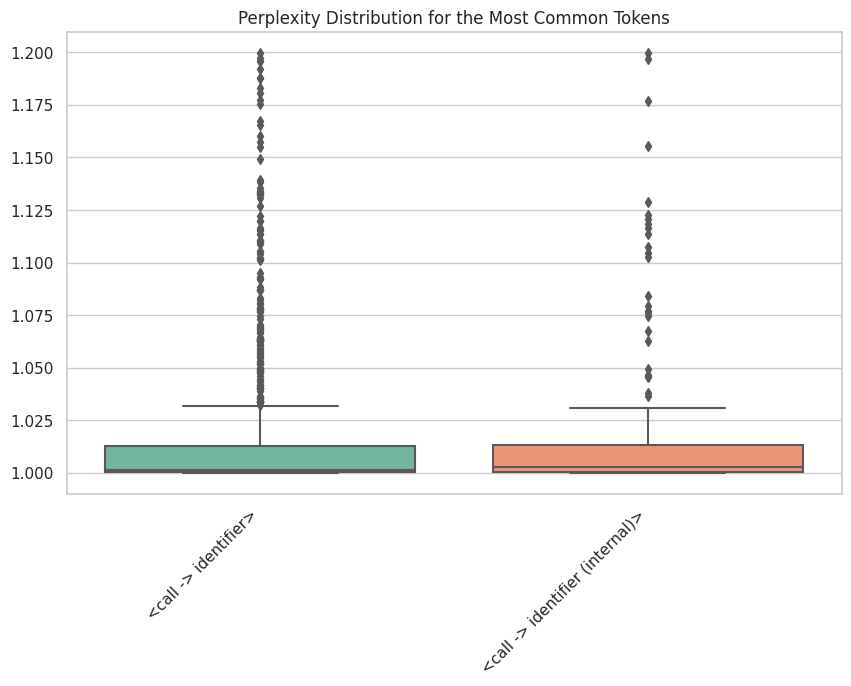

In [56]:
#|eval: false
# boxplot the distribution of perplexities for the most common tokens
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")

# most_common = token_cnt.most_common(15)
most_common_tokens = [token for token, _ in most_common]
most_common_perplexities = [
    list(filter(lambda x: x < 1.2, perplexity_dist[token]))
    for token in most_common_tokens
]

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(data=most_common_perplexities, palette="Set2")
ax.set_xticklabels(most_common_tokens)
ax.set_title("Perplexity Distribution for the Most Common Tokens")
plt.xticks(rotation=45, ha="right")
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()